# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

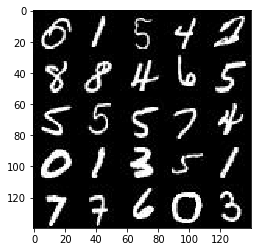

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

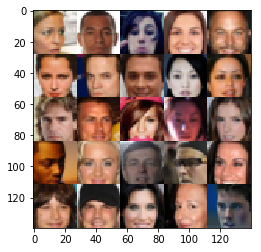

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [10]:
alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5

def leaky_relu(x, alpha):
    """
    A Leaky Rectified Linear Unit
    :param x: Input tensor
    :param alpha: Slope of the leaky output
    :return: Output tensor
    """
    return tf.maximum(alpha * x, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 0: 28x28x3 -> 14x14x64
        layer0 = tf.layers.conv2d(
            images, 64, 5, strides=2, padding='same', 
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer0 = leaky_relu(layer0, alpha)
        layer0 = tf.nn.dropout(layer0, d_dropout)
        
        # Layer 1: 14x14x64 -> 7x7x128
        layer1 = tf.layers.conv2d(
            layer0, 128, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)
        layer1 = tf.nn.dropout(layer1, d_dropout)
        
        # Layer 2: 4x4x256
        layer2 = tf.layers.conv2d(
            layer1, 256, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        layer2 = tf.nn.dropout(layer2, d_dropout)
        
        # Fully connected logits: 4x4x256 -> 4*4*256
        logits = tf.reshape(layer2, [-1, 4*4*256])
        logits = tf.contrib.layers.fully_connected(
            logits, 1, activation_fn=None,
            weights_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01)
        )
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 0 (fully connected): z -> 4x4x512
        layer0 = tf.contrib.layers.fully_connected(
            z, 4*4*512, activation_fn=None, 
            weights_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01)
        )
        layer0 = tf.reshape(layer0, [-1, 4, 4, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)
        layer0 = tf.nn.dropout(layer0, g_dropout)
        
        # Layer 1: 4x4x512 -> 7x7x256
        layer1 = tf.layers.conv2d_transpose(
            layer0, 256, 4, strides=1, padding='valid',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        layer1 = tf.nn.dropout(layer1, g_dropout)
        
        # Layer 2: 7x7x256 -> 14x14x128
        layer2 = tf.layers.conv2d_transpose(
            layer1, 128, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        layer2 = tf.nn.dropout(layer2, g_dropout)
        
        # Layer 3: 14x14x128 -> 28x28x64
        layer3 = tf.layers.conv2d_transpose(
            layer2, 64, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3, alpha)
        layer3 = tf.nn.dropout(layer3, g_dropout)
        
        # Output image: 28x28x64 -> 28x28x3
        logits = tf.layers.conv2d_transpose(
            layer3, out_channel_dim, 5, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [78]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discriminators, one for real images, and one for fake (generated)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # Use label smoothing, see https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    labels_real = tf.random_uniform(tf.shape(d_output_real), minval=0.9, maxval=1)
    labels_fake = tf.random_uniform(tf.shape(d_output_fake), minval=0, maxval=0.3)
    
    # For a real image, discriminator loss is deviation from an output of 1 (true)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=labels_real
    ))
    
    # For a fake image, discriminator loss is deviation from an output of 0 (false)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=labels_fake
    ))
    
    # Total discriminator loss is the sum of the real and fake image losses
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss is the opposite of the discriminator loss for fake images
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_output_fake)
    ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [79]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get all variables
    t_vars = tf.trainable_variables()
    
    # Get weights and biases for the discriminator and generator
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [81]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale the domain from (-0.5, 0.5) to (-1, 1), since we are using tanh in that range
                batch_images = batch_images * 2
                
                # Noise (Z) input for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimize weights and biases
                # Run g_opt twice, see https://github.com/carpedm20/DCGAN-tensorflow
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    g_train_loss = g_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [82]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 2.6462
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 4.3884
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.1372
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 6.2892
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 2.9060
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 3.0044


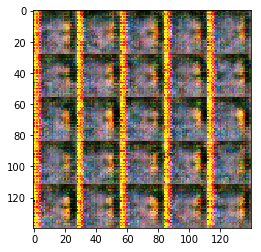

Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 2.8723
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 3.3148
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 3.7829
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 4.1187
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.7197


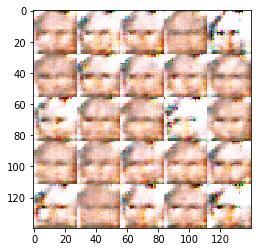

Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.3083


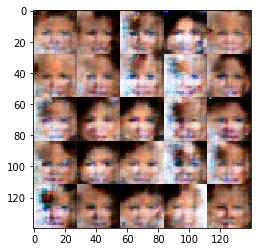

Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7708


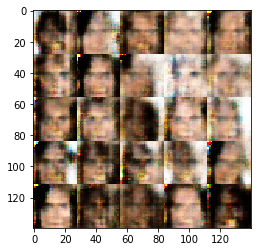

Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.0568


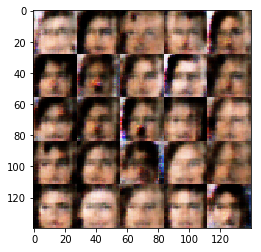

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8086


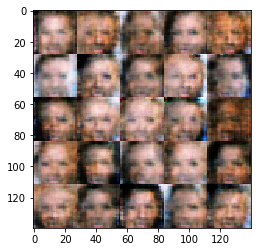

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0156


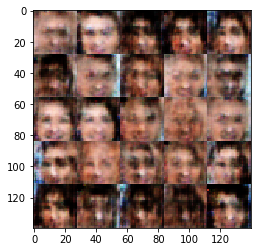

Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7121


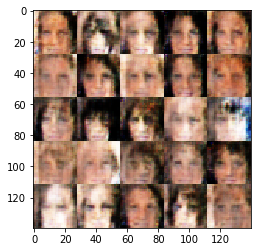

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7263


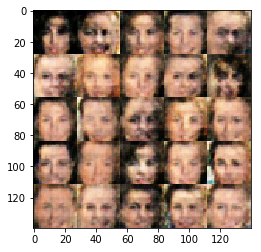

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.0039


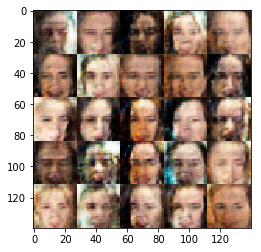

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9749


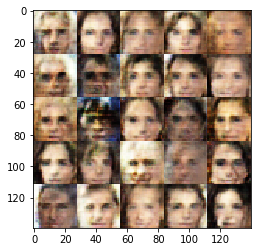

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9193


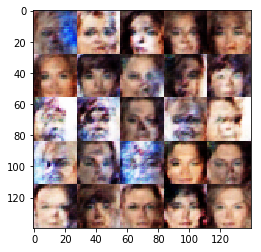

Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7566


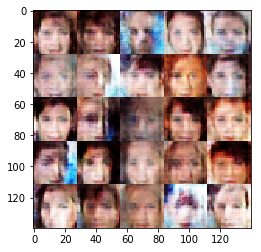

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6998


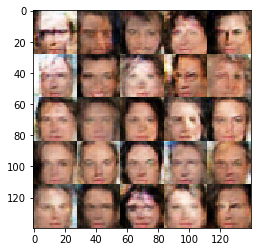

Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.9886


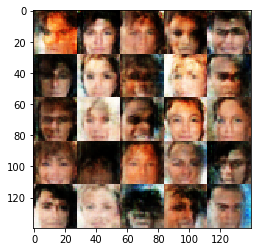

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8612


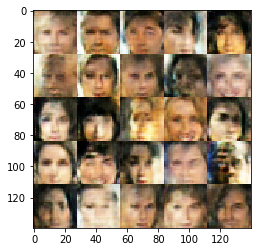

Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.7746


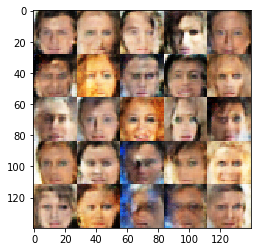

Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0008


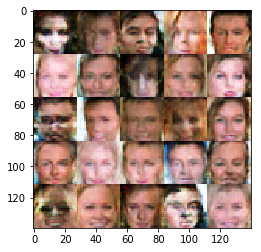

Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8422


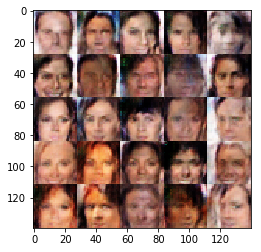

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8801


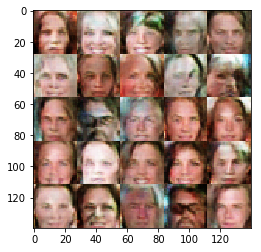

Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9056


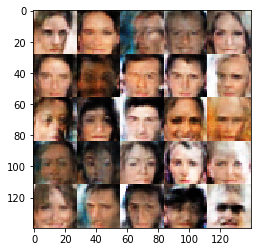

Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.0744


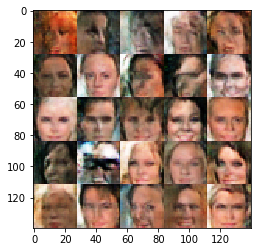

Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.3034


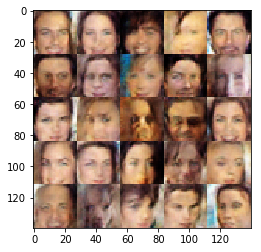

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9926


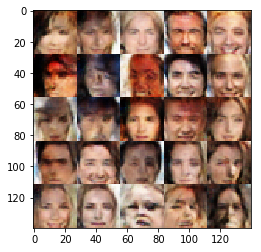

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.1086


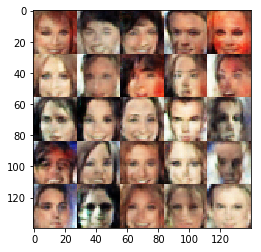

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8033


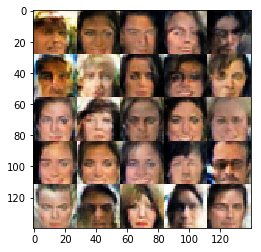

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9716


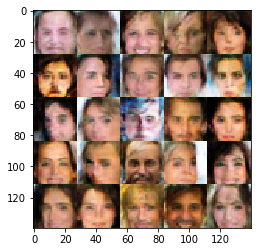

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9335


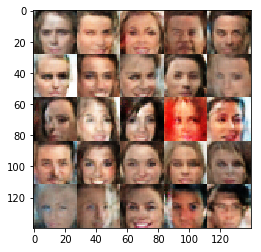

Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.1285


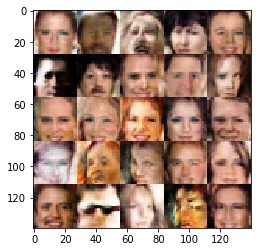

Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.9999


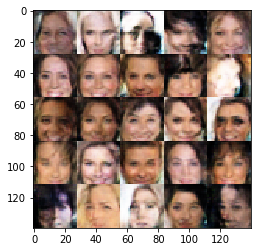

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 0.9580


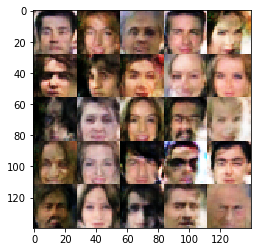

Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.0436


In [77]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.